In [3]:
!pip install qiskit-aer
from qiskit import QuantumCircuit
from qiskit_aer import Aer

In [5]:
# Cell 1: Imports and helper utilities
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import Aer

from qiskit.quantum_info import Statevector, DensityMatrix, Operator, partial_trace
from qiskit.visualization import (
    plot_state_city,
    plot_state_hinton,
    plot_state_qsphere,
    plot_bloch_multivector
)

# numerical utilities
def kron(*mats):
    out = np.array([1], dtype=complex)
    for M in mats:
        out = np.kron(out, M)
    return out

def dirac_str(statevec, n_qubits, tol=1e-8):
    parts = []
    for idx, amp in enumerate(statevec):
        if abs(amp) > tol:
            bits = format(idx, f'0{n_qubits}b')
            a = amp
            if abs(a.imag) < tol:
                amp_s = f'{a.real:+.4f}'
            else:
                amp_s = f'({a.real:+.4f}{a.imag:+.4f}j)'
            parts.append(f'{amp_s}|{bits}⟩')
    return ' + '.join(parts) if parts else '0'

def von_neumann_entropy(rho, tol=1e-12):
    vals = np.linalg.eigvals(rho)
    vals = np.real_if_close(vals)
    vals = np.where(vals < 0, 0.0, vals)
    vals = vals[vals > tol]
    return float(-np.sum(vals * np.log2(vals)))

def concurrence_from_rho(rho):
    sy = np.array([[0,-1j],[1j,0]], dtype=complex)
    YY = np.kron(sy, sy)
    R = rho.dot(YY).dot(np.conjugate(rho)).dot(YY)
    ev = np.real_if_close(np.linalg.eigvals(R))
    ev = np.where(ev < 0, 0.0, ev)
    ev = np.sort(ev)[::-1]
    sqrt_ev = np.sqrt(ev)
    C = max(0.0, sqrt_ev[0] - sqrt_ev[1] - sqrt_ev[2] - sqrt_ev[3])
    return float(C)

def plot_matrix(mat, title='matrix', labels=None):
    plt.figure(figsize=(4,4))
    plt.imshow(np.abs(mat), interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    if labels:
        plt.xticks(range(len(labels)), labels, rotation=90)
        plt.yticks(range(len(labels)), labels)
    plt.tight_layout()

In [11]:
!pip install qiskit
!pip install qiskit-aer
!pip install matplotlib
!pip install pylatexenc

In [10]:
# Cell 2: Build and draw HSHT single-qubit circuit (H -> S -> H -> T)
qc_hsht = QuantumCircuit(1, name='HSHT')
qc_hsht.h(0)
qc_hsht.s(0)
qc_hsht.h(0)
qc_hsht.t(0)
print(qc_hsht.draw(output='text'))

   ┌───┐┌───┐┌───┐┌───┐
q: ┤ H ├┤ S ├┤ H ├┤ T ├
   └───┘└───┘└───┘└───┘


In [12]:
# Cell 3: Apply HSHT to |0> and |1>, show statevectors (Dirac) and draw Bloch sphere
sv0 = Statevector.from_label('0').evolve(qc_hsht)
sv1 = Statevector.from_label('1').evolve(qc_hsht)

print("HSHT |0> ->", dirac_str(sv0.data, 1))
print("HSHT |1> ->", dirac_str(sv1.data, 1))

# Bloch multivector plot for single-qubit states
fig_bloch_0 = plot_bloch_multivector(sv0.data)
fig_bloch_1 = plot_bloch_multivector(sv1.data)
# To save: fig_bloch_0.savefig('hsht_bloch_0.png')
# To display inline, just run the cell in Jupyter.


HSHT |0> -> (+0.5000+0.5000j)|0⟩ + +0.7071|1⟩
HSHT |1> -> (+0.5000-0.5000j)|0⟩ + (+0.0000+0.7071j)|1⟩


In [14]:
# Cell 4: Check reversibility of HSHT (numerical) — corrected inverse circuit and text drawing (no mpl)

from qiskit.quantum_info import Operator

# Original HSHT circuit assumed defined earlier as qc_hsht
U = Operator(qc_hsht).data
U_dag = U.conj().T
I2 = np.eye(2, dtype=complex)
print("Max deviation U*U^† - I:", np.max(np.abs(U.dot(U_dag) - I2)))

# Build explicit inverse circuit: U = H S H T  ->  U^† = T^† H S^† H
qc_hsht_inv = QuantumCircuit(1, name='HSHT_inv')
qc_hsht_inv.tdg(0)   # T^†
qc_hsht_inv.h(0)     # H
qc_hsht_inv.sdg(0)   # S^†
qc_hsht_inv.h(0)     # H

# Use text drawer to avoid mpl / pylatexenc requirement
print("\nHSHT inverse circuit (text):")
print(qc_hsht_inv.draw(output='text', fold=100))

# Numerical verification: compose U and U_inv and check identity
U_op = Operator(qc_hsht)
Uinv_op = Operator(qc_hsht_inv)
prod = (U_op.compose(Uinv_op)).data   # U * U_inv
print("\nMax deviation (U * U_inv - I):", np.max(np.abs(prod - np.eye(2, dtype=complex))))

# Also check U_inv * U (both should be identity)
prod2 = (Uinv_op.compose(U_op)).data
print("Max deviation (U_inv * U - I):", np.max(np.abs(prod2 - np.eye(2, dtype=complex))))

Max deviation U*U^† - I: 4.440892098500626e-16

HSHT inverse circuit (text):
   ┌─────┐┌───┐┌─────┐┌───┐
q: ┤ Tdg ├┤ H ├┤ Sdg ├┤ H ├
   └─────┘└───┘└─────┘└───┘

Max deviation (U * U_inv - I): 4.440892098500626e-16
Max deviation (U_inv * U - I): 4.440892098500626e-16


In [16]:
# Cell 5: Build H -> CNOT entangler circuit and draw (TEXT MODE, no mpl)

qc_ent = QuantumCircuit(2, name='H-CNOT')
qc_ent.h(0)
qc_ent.cx(0, 1)

print("H → CNOT entangling circuit (text drawer):")
print(qc_ent.draw(output='text', fold=100))

H → CNOT entangling circuit (text drawer):
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


In [17]:
# Cell 6: Prepare all 4 computational inputs, run entangler, compute statevectors & plot city/hinton
basis = ['00','01','10','11']
results = {}
for b in basis:
    sv_in = Statevector.from_label(b)
    sv_out = sv_in.evolve(qc_ent)
    results[b] = sv_out

# Print dirac forms
for b, sv in results.items():
    print(f"Input |{b}> -> {dirac_str(sv.data, 2)}")

# Visualize one of the outputs (e.g., from |00> -> should produce a Bell state)
fig_city = plot_state_city(results['00'])
fig_hinton = plot_state_hinton(results['00'])
# Qsphere visualization (optional)
fig_qsphere = plot_state_qsphere(results['00'].data)


Input |00> -> +0.7071|00⟩ + +0.7071|11⟩
Input |01> -> +0.7071|00⟩ + -0.7071|11⟩
Input |10> -> +0.7071|01⟩ + +0.7071|10⟩
Input |11> -> -0.7071|01⟩ + +0.7071|10⟩


In [18]:
# Cell 7: Construct Bell states explicitly and compare with circuit outputs
# Standard Bell states in computational basis |00>,|01>,|10>,|11>
zero = np.array([1,0], dtype=complex)
one  = np.array([0,1], dtype=complex)
b00 = np.kron(zero, zero)
b01 = np.kron(zero, one)
b10 = np.kron(one, zero)
b11 = np.kron(one, one)

bell_phi_plus  = (b00 + b11) / np.sqrt(2)  # |Φ+>
bell_phi_minus = (b00 - b11) / np.sqrt(2)  # |Φ->
bell_psi_plus  = (b01 + b10) / np.sqrt(2)  # |Ψ+>
bell_psi_minus = (b01 - b10) / np.sqrt(2)  # |Ψ->

bells = {
    '|Φ+>': bell_phi_plus,
    '|Φ->': bell_phi_minus,
    '|Ψ+>': bell_psi_plus,
    '|Ψ->': bell_psi_minus
}

# Compare overlaps
for inp, sv in results.items():
    overlaps = {name: abs(np.vdot(vec, sv.data)) for name,vec in bells.items()}
    print(f"Input |{inp}> overlaps with Bell states: {overlaps}")


Input |00> overlaps with Bell states: {'|Φ+>': np.float64(0.9999999999999998), '|Φ->': np.float64(0.0), '|Ψ+>': np.float64(0.0), '|Ψ->': np.float64(0.0)}
Input |01> overlaps with Bell states: {'|Φ+>': np.float64(0.0), '|Φ->': np.float64(0.9999999999999998), '|Ψ+>': np.float64(0.0), '|Ψ->': np.float64(0.0)}
Input |10> overlaps with Bell states: {'|Φ+>': np.float64(0.0), '|Φ->': np.float64(0.0), '|Ψ+>': np.float64(0.9999999999999998), '|Ψ->': np.float64(0.0)}
Input |11> overlaps with Bell states: {'|Φ+>': np.float64(0.0), '|Φ->': np.float64(0.0), '|Ψ+>': np.float64(0.0), '|Ψ->': np.float64(0.9999999999999998)}


In [19]:
# Cell 8: Entanglement quantifiers: reduced density matrices, entropy, concurrence
# We'll analyze the output for input |00> (the canonical Bell generator)
sv_bell = results['00']   # statevector object for |00> -> entangled output
rho_full = DensityMatrix(sv_bell)  # full 4x4 density matrix

# Reduced density matrices
rho_q0 = partial_trace(rho_full, [1])   # trace out qubit-1 -> density for qubit-0
rho_q1 = partial_trace(rho_full, [0])   # trace out qubit-0 -> density for qubit-1

# Convert to numpy arrays
rho_full_np = rho_full.data
rho_q0_np = np.array(rho_q0.data)
rho_q1_np = np.array(rho_q1.data)

print("Reduced density matrix rho_q0:\n", np.round(rho_q0_np, 6))
print("Reduced density matrix rho_q1:\n", np.round(rho_q1_np, 6))

# von Neumann entropy of reduced states (should be 1 for perfect Bell states)
S_q0 = von_neumann_entropy(rho_q0_np)
S_q1 = von_neumann_entropy(rho_q1_np)
print("Von Neumann entropies: S(q0)=", S_q0, " S(q1)=", S_q1)

# Concurrence for two-qubit state (should be 1 for maximally entangled pure Bell)
C = concurrence_from_rho(rho_full_np)
print("Concurrence (two-qubit) =", C)


Reduced density matrix rho_q0:
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
Reduced density matrix rho_q1:
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
Von Neumann entropies: S(q0)= 1.0  S(q1)= 1.0
Concurrence (two-qubit) = 0.9999999999999994


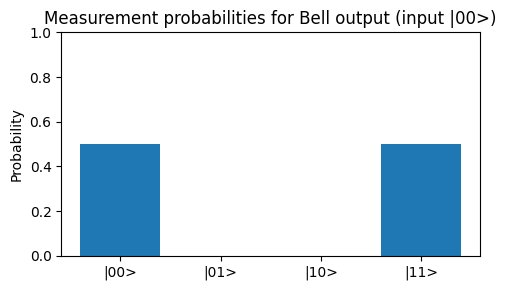

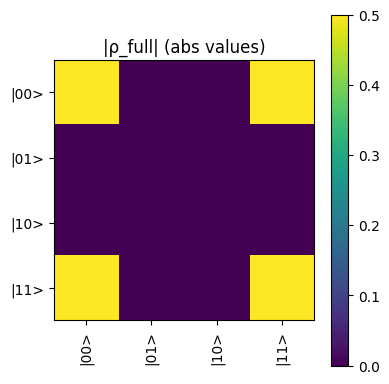

In [20]:
# Cell 9: Plot probability distribution and density matrix images for the Bell state
# Probabilities (|amplitude|^2)
probs = np.abs(sv_bell.data)**2
labels = ['|00>','|01>','|10>','|11>']

plt.figure(figsize=(5,3))
plt.bar(labels, probs)
plt.title('Measurement probabilities for Bell output (input |00>)')
plt.ylabel('Probability')
plt.ylim(0,1)
plt.tight_layout()

# Plot absolute value of density matrix (full)
plot_matrix(rho_full_np, title='|ρ_full| (abs values)', labels=labels)


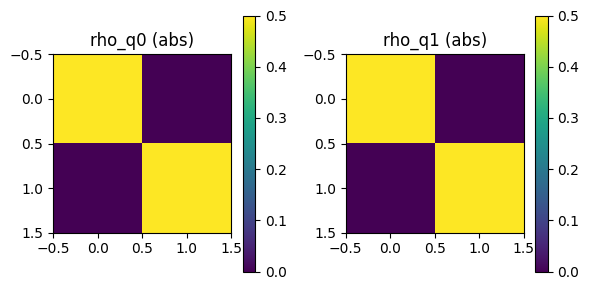

In [21]:
# Cell 10: Additional: show partial trace result visually and show why reduced states are mixed
# Plot density matrices of the reduced single-qubit states
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('rho_q0 (abs)')
plt.imshow(np.abs(rho_q0_np), interpolation='nearest')
plt.colorbar()
plt.subplot(1,2,2)
plt.title('rho_q1 (abs)')
plt.imshow(np.abs(rho_q1_np), interpolation='nearest')
plt.colorbar()
plt.tight_layout()
